<a href="https://colab.research.google.com/github/sush0677/predictive-analysis/blob/main/predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Step 1: Importing Libraries***

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine Learning - Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler

# Machine Learning - Models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


# ***Step 2: Load and Preprocess Data***

In [ ]:
# Load dataset
df = pd.read_csv('/content/loan_default_prediction_100k.csv')

# Preprocessing
X = df.drop('Default', axis=1)  # Assuming 'Default' is your target variable
y = df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ***Step 3: Define Base Models and Meta-model***

In [ ]:
# Base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lr', LogisticRegression(max_iter=1000))
]

# Meta-model
meta_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)


# ***Step 4: Define and Train Stacking Ensemble***

In [ ]:
# Stacking ensemble
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Training
stacking_model.fit(X_train_scaled, y_train)


StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              im...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lr', LogisticRegression(max_iter=1000))],
                   final_estimator=GradientBoostingClassifier(n_estimators=50,
                                                              random_state=42))

# ***Step 5: Predictions and Evaluation***

In [ ]:
# Predictions
y_pred = stacking_model.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
cr = classification_report(y_test, y_pred)
print(cr)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Accuracy: 50.02%
              precision    recall  f1-score   support

           0       0.50      0.21      0.30      9960
           1       0.50      0.78      0.61     10040

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.50      0.50      0.46     20000

Confusion Matrix:
[[2126 7834]
 [2162 7878]]


# ***Step 6: Visualization of Confusion Matrix and Classification Report***

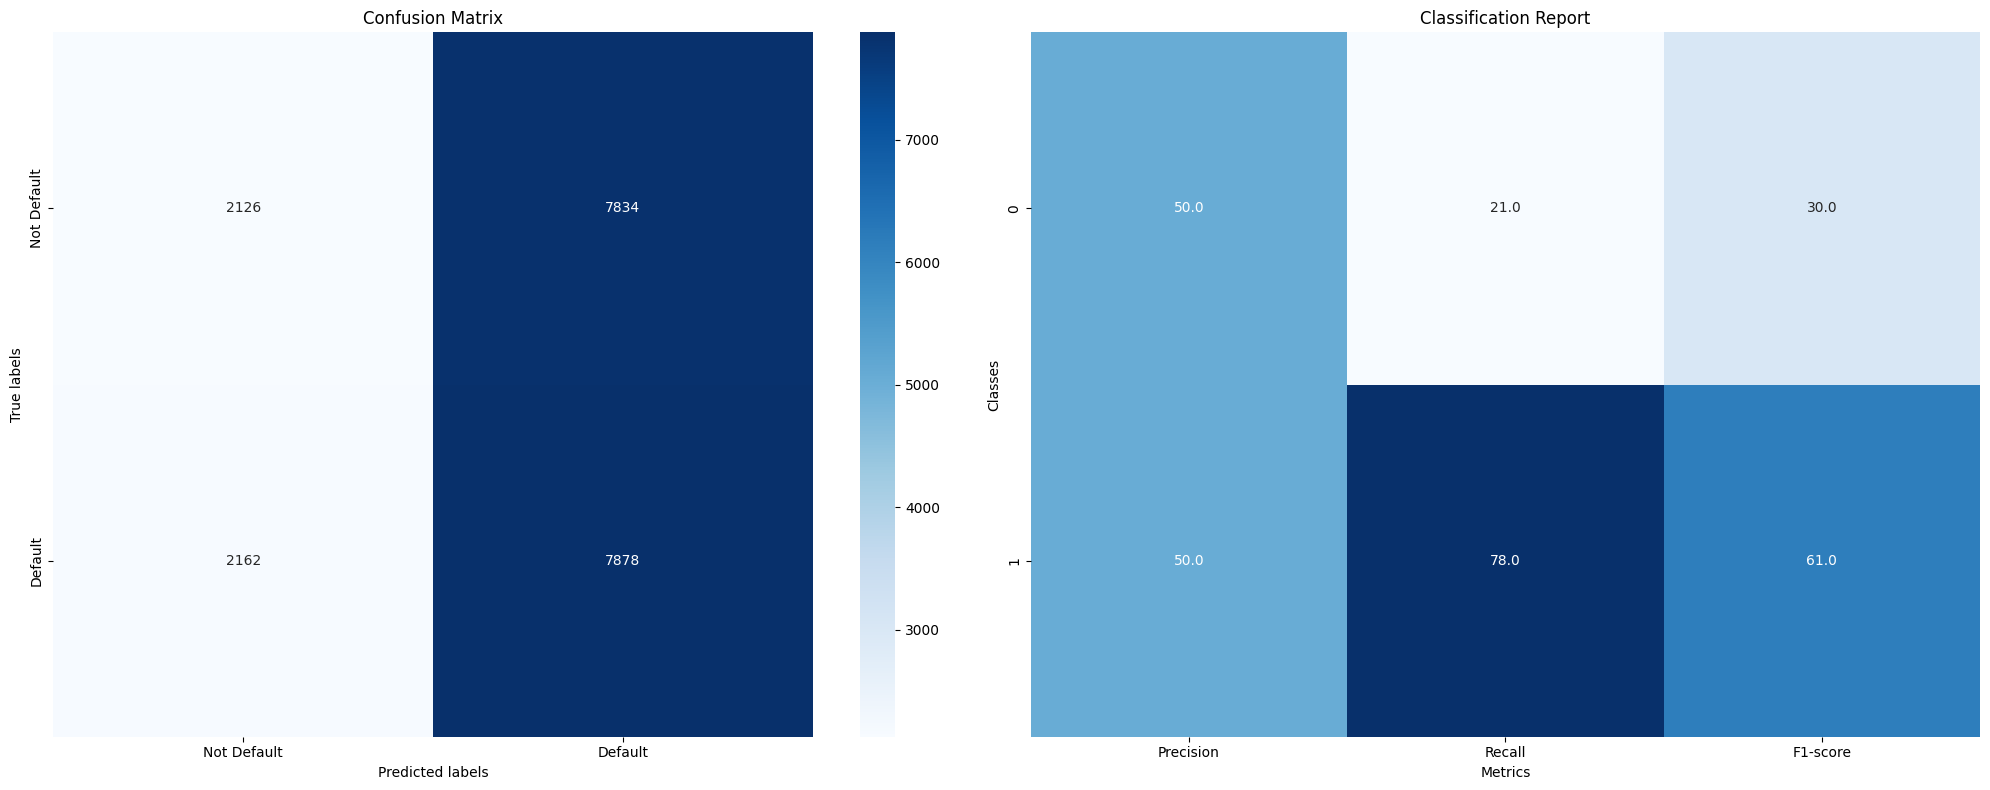

In [ ]:
def plot_classification_report(cr, ax, title='Classification Report', cmap=plt.cm.Blues):
    lines = cr.split('\n')
    classes = []
    plotMat = []
    for line in lines[2: (len(lines) - 5)]:  # Exclude the summary rows
        t = line.split()
        classes.append(t[0])
        # Convert to percentages
        v = [float(x) * 100 for x in t[1: len(t) - 1]]
        plotMat.append(v)

    plotMat = np.array(plotMat)
    sns.heatmap(plotMat, annot=True, cmap=cmap, ax=ax, cbar=False,
                xticklabels=['Precision', 'Recall', 'F1-score'],
                yticklabels=classes, fmt=".1f")
    ax.set_title(title)
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Classes')

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot Confusion Matrix (Assuming cm is already defined)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax[0],
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'])
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion Matrix')

# Plot Classification Report
plot_classification_report(cr, ax=ax[1], title='Classification Report', cmap=plt.cm.Blues)

plt.tight_layout()
plt.show()


# ***Step 7: Model Evaluation and Interpretation***

Feature Importance: Understanding which features are most influential in predicting loan default can provide insights and help in feature engineering.

In [ ]:
feature_importances = stacking_model.final_estimator_.feature_importances_
features = X_train.columns[:3]  # Select the first 3 features

# Constructing DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head())


             Feature  Importance
1       AnnualIncome    0.442675
2  DebtToIncomeRatio    0.425586
0        CreditScore    0.131740


Advanced Model Evaluation: Beyond accuracy and F1 scores, consider evaluating your model using ROC-AUC curves or Precision-Recall curves, especially if dealing with imbalanced datasets.

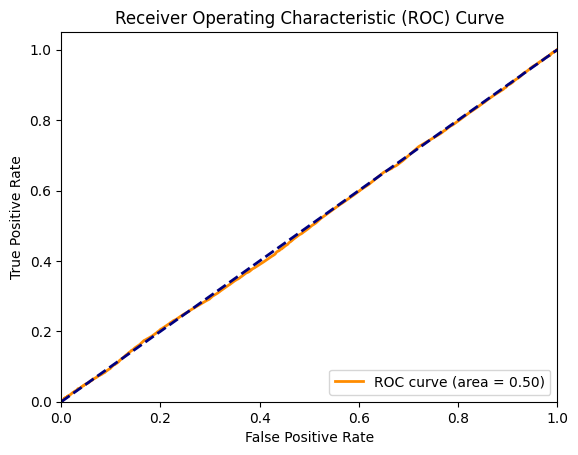

In [ ]:
# Assuming binary classification and y_test, y_pred_proba are defined
y_pred_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
